[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rfsan/r5/blob/main/notebooks/r5_part02_model.ipynb)

# Prueba R5 - Exploración de los datos y entrenamiento de los modelos

## Importar librerías, cargar los datos y crear helper functions

In [1]:
!pip install -U "scikit-learn==1.2.1"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 17.6 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2


In [2]:
# analysis
import numpy as np
import pandas as pd

# db connection
import psycopg2
import pandas.io.sql as sqlio

# ml
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# utils
import joblib
import gzip

np.random.seed(31415)

In [3]:
# helpers

def count_and_percentage(series):
    return pd.concat([
        series.value_counts(), 
        series.value_counts(normalize=True)*100
        ],
        axis=1,
        keys=['Count', 'Percentage']
        )
    
def cat_target_summary(df, feature, target):
    df_tmp = pd.concat([
        count_and_percentage(df[feature]), 
        df.groupby(feature)[target].mean()*100
        ],
        axis=1,
    )
    df_tmp.reset_index(inplace=True)
    df_tmp.columns = [feature, 'Count', 'Percentage', 'FraudPercentage']
    return df_tmp

In [4]:
db_password = "LA CONTRASEÑA ESTÁ EN EL CORREO!"
connection = psycopg2.connect(
    host="db.kowllitbpmdnyshbtbzn.supabase.co",
    database="postgres",
    port="5432",
    user="postgres",
    password=db_password,
)
cursor = connection.cursor()

In [5]:
sql = """
    SELECT *
    FROM public.fraudes
"""
df = sqlio.read_sql_query(sql, connection)
df.head(5)

,Monthh,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Yearr,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,...,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,...,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,...,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,...,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,...,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision


## Explorar los datos

Nuestro objetivo es lograr un modelo que nos diga la probabilidad de que una reclamación sea fraude o no. La columna que guarda dicha información es `FraudFound_P`

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Monthh                15420 non-null  object
 1   WeekOfMonth           15420 non-null  int64 
 2   DayOfWeek             15420 non-null  object
 3   Make                  15420 non-null  object
 4   AccidentArea          15420 non-null  object
 5   DayOfWeekClaimed      15420 non-null  object
 6   MonthClaimed          15420 non-null  object
 7   WeekOfMonthClaimed    15420 non-null  int64 
 8   Sex                   15420 non-null  object
 9   MaritalStatus         15420 non-null  object
 10  Age                   15420 non-null  int64 
 11  Fault                 15420 non-null  object
 12  PolicyType            15420 non-null  object
 13  VehicleCategory       15420 non-null  object
 14  VehiclePrice          15420 non-null  object
 15  FraudFound_P          15420 non-null

In [7]:
df.isna().sum()

Monthh                  0
WeekOfMonth             0
DayOfWeek               0
Make                    0
AccidentArea            0
DayOfWeekClaimed        0
MonthClaimed            0
WeekOfMonthClaimed      0
Sex                     0
MaritalStatus           0
Age                     0
Fault                   0
PolicyType              0
VehicleCategory         0
VehiclePrice            0
FraudFound_P            0
PolicyNumber            0
RepNumber               0
Deductible              0
DriverRating            0
Days_Policy_Accident    0
Days_Policy_Claim       0
PastNumberOfClaims      0
AgeOfVehicle            0
AgeOfPolicyHolder       0
PoliceReportFiled       0
WitnessPresent          0
AgentType               0
NumberOfSuppliments     0
AddressChange_Claim     0
NumberOfCars            0
Yearr                   0
BasePolicy              0
dtype: int64

### Nuestro target

In [8]:
count_and_percentage(df['FraudFound_P'])

,Count,Percentage
0,14497,94.014267
1,923,5.985733


Nuestro target está bastante desbalanceado. Debemos tener esto presente al momento de entrenar los modelos.

### Investigación de las demás columnas y su relación con FraudFound_P

Para que el notebook no sea tan pesado solo usaré gráficas cuando sean variables numéricas continuas, donde es importante ver la tendencia.

#### "Monthh" - Cat Nominal

In [9]:
cat_target_summary(df, "Monthh", 'FraudFound_P')

,Monthh,Count,Percentage,FraudPercentage
0,Jan,1411,9.150454,6.165840
1,May,1367,8.865110,6.876372
2,Mar,1360,8.819715,7.500000
3,Jun,1321,8.566796,6.056018
4,Oct,1305,8.463035,5.363985
5,Dec,1285,8.333333,4.824903
6,Apr,1280,8.300908,6.250000
7,Feb,1266,8.210117,6.477093
8,Jul,1257,8.151751,4.773270
9,Sep,1240,8.041505,6.129032


No todos los meses son del mismo año

#### "WeekOfMonth" - Num Discrete


In [10]:
cat_target_summary(df, "WeekOfMonth", 'FraudFound_P')

,WeekOfMonth,Count,Percentage,FraudPercentage
0,1,3187,20.667964,6.275494
1,2,3558,23.073930,6.323777
2,3,3640,23.605707,5.906593
3,4,3398,22.036316,5.650383
4,5,1637,10.616083,5.558949


#### "DayOfWeek" - Cat Nominal

In [11]:
cat_target_summary(df, "DayOfWeek", 'FraudFound_P')

,DayOfWeek,Count,Percentage,FraudPercentage
0,Monday,2616,16.964981,6.116208
1,Friday,2445,15.856031,6.298569
2,Tuesday,2300,14.915694,5.217391
3,Thursday,2173,14.092088,5.522319
4,Wednesday,2159,14.001297,5.326540
5,Saturday,1982,12.853437,6.659939
6,Sunday,1745,11.316472,6.991404


#### "Make" - Cat Nominal

In [12]:
cat_target_summary(df, 'Make', 'FraudFound_P')

,Make,Count,Percentage,FraudPercentage
0,Pontiac,3837,24.883268,5.551212
1,Toyota,3121,20.239948,5.959628
2,Honda,2801,18.164721,6.390575
3,Mazda,2354,15.265888,5.225149
4,Chevrolet,1681,10.901427,5.591910
5,Accura,472,3.060960,12.500000
6,Ford,450,2.918288,7.333333
7,VW,283,1.835279,2.826855
8,Dodge,109,0.706874,1.834862
9,Saab,108,0.700389,10.185185


#### "AccidentArea" - Binary

In [13]:
cat_target_summary(df, "AccidentArea", 'FraudFound_P')

,AccidentArea,Count,Percentage,FraudPercentage
0,Urban,13822,89.636835,5.715526
1,Rural,1598,10.363165,8.322904


#### "DayOfWeekClaimed" - Cat Nominal



In [14]:
cat_target_summary(df, "DayOfWeekClaimed", 'FraudFound_P')

,DayOfWeekClaimed,Count,Percentage,FraudPercentage
0,Monday,3757,24.364462,5.749268
1,Tuesday,3375,21.887160,5.866667
2,Wednesday,2951,19.137484,6.370722
3,Thursday,2660,17.250324,5.413534
4,Friday,2497,16.193256,6.567881
5,Saturday,127,0.823606,7.874016
6,Sunday,52,0.337224,5.769231
7,0,1,0.006485,0.000000


Hay una entrada con un cero. Podemos quitarla.

In [15]:
df = df[df['DayOfWeekClaimed'] != '0']

#### "MonthClaimed" - Cat Nominal

In [16]:
cat_target_summary(df, "MonthClaimed", 'FraudFound_P')

,MonthClaimed,Count,Percentage,FraudPercentage
0,Jan,1446,9.378040,6.362379
1,May,1411,9.151047,7.228916
2,Mar,1348,8.742461,7.195846
3,Oct,1339,8.684091,5.451830
4,Jun,1293,8.385758,6.032483
5,Feb,1287,8.346845,6.060606
6,Nov,1285,8.333874,3.579767
7,Apr,1271,8.243077,6.451613
8,Sep,1242,8.054997,6.280193
9,Jul,1225,7.944743,4.571429


#### "WeekOfMonthClaimed" - Num Discrete

In [17]:
cat_target_summary(df, "WeekOfMonthClaimed", 'FraudFound_P')

,WeekOfMonthClaimed,Count,Percentage,FraudPercentage
0,1,3449,22.368506,6.378660
1,2,3720,24.126078,5.591398
2,3,3583,23.237564,6.168016
3,4,3433,22.264738,6.087970
4,5,1234,8.003113,5.267423


#### "Sex" - Binary

In [18]:
cat_target_summary(df, "Sex", 'FraudFound_P')

,Sex,Count,Percentage,FraudPercentage
0,Male,12999,84.305078,6.292792
1,Female,2420,15.694922,4.338843


#### "MaritalStatus" - Cat Nominal

In [19]:
cat_target_summary(df, 'MaritalStatus', 'FraudFound_P')

,MaritalStatus,Count,Percentage,FraudPercentage
0,Married,10625,68.908490,6.014118
1,Single,4683,30.371619,5.936366
2,Divorced,76,0.492898,3.947368
3,Widow,35,0.226993,8.571429


#### "Age" & "AgeOfPolicyHolder"

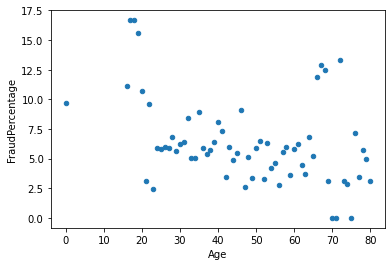

In [20]:
cat_target_summary(df, "Age", 'FraudFound_P').plot.scatter(x='Age', y='FraudPercentage')

Tenemos varias edades con 0. Vamos a explorar la columna relacionada `AgeOfPolicyHolder`.

In [21]:
df['AgeOfPolicyHolder'].value_counts()

31 to 35    5593
36 to 40    4043
41 to 50    2828
51 to 65    1392
26 to 30     613
over 65      508
16 to 17     319
21 to 25     108
18 to 20      15
Name: AgeOfPolicyHolder, dtype: int64

In [22]:
df[df['Age'] == 0]['AgeOfPolicyHolder'].value_counts()

16 to 17    319
Name: AgeOfPolicyHolder, dtype: int64

In [23]:
cat_target_summary(df, "AgeOfPolicyHolder", 'FraudFound_P')

,AgeOfPolicyHolder,Count,Percentage,FraudPercentage
0,31 to 35,5593,36.273429,6.436617
1,36 to 40,4043,26.220896,5.861984
2,41 to 50,2828,18.341008,5.091938
3,51 to 65,1392,9.027823,5.028736
4,26 to 30,613,3.975615,5.383361
5,over 65,508,3.294636,5.905512
6,16 to 17,319,2.068876,9.717868
7,21 to 25,108,0.700435,14.814815
8,18 to 20,15,0.097283,13.333333


Vamos a usar la columna `AgeOfPolicyHolder` porque no tiene ceros y porque tiene las edades agrupadas.

#### "Fault" - Binary

In [24]:
cat_target_summary(df, "Fault", 'FraudFound_P')

,Fault,Count,Percentage,FraudPercentage
0,Policy Holder,11229,72.825734,7.890284
1,Third Party,4190,27.174266,0.883055


#### "PolicyType" - Cat Nominal

In [25]:
cat_target_summary(df, "PolicyType", 'FraudFound_P')

,PolicyType,Count,Percentage,FraudPercentage
0,Sedan - Collision,5584,36.215059,6.876791
1,Sedan - Liability,4987,32.343213,0.721877
2,Sedan - All Perils,4086,26.499773,10.058737
3,Sport - Collision,348,2.256956,13.793103
4,Utility - All Perils,340,2.205072,12.058824
5,Utility - Collision,30,0.194565,10.000000
6,Sport - All Perils,22,0.142681,0.000000
7,Utility - Liability,21,0.136196,0.000000
8,Sport - Liability,1,0.006486,0.000000


#### "VehicleCategory" - Cat Nominal

In [26]:
cat_target_summary(df, "VehicleCategory", 'FraudFound_P')

,VehicleCategory,Count,Percentage,FraudPercentage
0,Sedan,9670,62.714832,8.221303
1,Sport,5358,34.749335,1.567749
2,Utility,391,2.535832,11.253197


#### "VehiclePrice" - Cat Ordinal

In [27]:
cat_target_summary(df, "VehiclePrice", 'FraudFound_P')

,VehiclePrice,Count,Percentage,FraudPercentage
0,20000 to 29000,8079,52.396394,5.211041
1,30000 to 39000,3533,22.913289,4.953297
2,more than 69000,2163,14.028147,8.737864
3,less than 20000,1096,7.108113,9.397810
4,40000 to 59000,461,2.989818,6.724512
5,60000 to 69000,87,0.564239,4.597701


#### "PolicyNumber" - Discard

In [28]:
cat_target_summary(df, "PolicyNumber", 'FraudFound_P')

,PolicyNumber,Count,Percentage,FraudPercentage
0,1,1,0.006486,0.0
1,2,1,0.006486,0.0
2,3,1,0.006486,0.0
3,4,1,0.006486,0.0
4,5,1,0.006486,0.0
...,...,...,...,...
15414,15416,1,0.006486,100.0
15415,15417,1,0.006486,0.0
15416,15418,1,0.006486,100.0
15417,15419,1,0.006486,0.0


Parece ser un número único por entrada. Podemos descartar esta columna.

#### "RepNumber" - Num Discrete

In [29]:
cat_target_summary(df, "RepNumber", 'FraudFound_P')

,RepNumber,Count,Percentage,FraudPercentage
0,1,987,6.401193,6.382979
1,2,956,6.200143,5.753138
2,3,949,6.154744,6.322445
3,4,912,5.914780,5.482456
4,5,987,6.401193,5.268490
5,6,942,6.109346,7.006369
6,7,1069,6.933005,6.922357
7,8,931,6.038005,5.585392
8,9,999,6.479019,6.506507
9,10,986,6.394708,6.693712


#### "Deductible" - Num Discrete

In [30]:
cat_target_summary(df, "Deductible", 'FraudFound_P')

,Deductible,Count,Percentage,FraudPercentage
0,300,8,0.051884,25.000000
1,400,14837,96.225436,5.769360
2,500,263,1.705688,17.870722
3,700,311,2.016992,5.787781


#### "DriverRating" - Num Discrete

In [31]:
cat_target_summary(df, "DriverRating", 'FraudFound_P')

,DriverRating,Count,Percentage,FraudPercentage
0,1,3944,25.578831,5.882353
1,2,3800,24.644919,5.631579
2,3,3884,25.189701,6.230690
3,4,3791,24.586549,6.198892


#### 'Days_Policy_Accident' - Cat Ordinal

In [32]:
cat_target_summary(df, "Days_Policy_Accident", 'FraudFound_P')

,Days_Policy_Accident,Count,Percentage,FraudPercentage
0,more than 30,15246,98.878008,5.935983
1,none,55,0.356703,16.363636
2,8 to 15,55,0.356703,9.090909
3,15 to 30,49,0.317790,6.122449
4,1 to 7,14,0.090797,7.142857


#### 'Days_Policy_Claim' - Cat Ordinal

In [33]:
cat_target_summary(df, "Days_Policy_Claim", 'FraudFound_P')

,Days_Policy_Claim,Count,Percentage,FraudPercentage
0,more than 30,15342,99.500616,5.957502
1,15 to 30,56,0.363188,10.714286
2,8 to 15,21,0.136196,14.285714


#### 'PastNumberOfClaims' - Cat Ordinal

In [34]:
cat_target_summary(df, "PastNumberOfClaims", 'FraudFound_P')

,PastNumberOfClaims,Count,Percentage,FraudPercentage
0,2 to 4,5485,35.572994,5.360073
1,none,4351,28.218432,7.791312
2,1,3573,23.172709,6.213266
3,more than 4,2010,13.035865,3.383085


#### 'AgeOfVehicle' - Cat Ordinal

In [35]:
cat_target_summary(df, "AgeOfVehicle", 'FraudFound_P')

,AgeOfVehicle,Count,Percentage,FraudPercentage
0,7 years,5807,37.661327,5.596694
1,more than 7,3981,25.818795,5.174579
2,6 years,3448,22.362021,6.612529
3,5 years,1357,8.800830,7.000737
4,new,372,2.412608,8.602151
5,4 years,229,1.485181,9.170306
6,3 years,152,0.985797,8.552632
7,2 years,73,0.473442,4.109589


#### 'PoliceReportFiled' - Binary

In [36]:
cat_target_summary(df, "PoliceReportFiled", 'FraudFound_P')

,PoliceReportFiled,Count,Percentage,FraudPercentage
0,No,14991,97.224204,6.050297
1,Yes,428,2.775796,3.738318


#### 'WitnessPresent' - Binary

In [37]:
cat_target_summary(df, "WitnessPresent", 'FraudFound_P')

,WitnessPresent,Count,Percentage,FraudPercentage
0,No,15332,99.435761,6.000522
1,Yes,87,0.564239,3.448276


#### 'AgentType' - Binary

In [38]:
cat_target_summary(df, "AgentType", 'FraudFound_P')

,AgentType,Count,Percentage,FraudPercentage
0,External,15178,98.436993,6.054816
1,Internal,241,1.563007,1.659751


#### 'NumberOfSuppliments' - Cat Ordinal

In [39]:
cat_target_summary(df, "NumberOfSuppliments", 'FraudFound_P')

,NumberOfSuppliments,Count,Percentage,FraudPercentage
0,none,7046,45.696868,6.698836
1,more than 5,3867,25.079447,5.042669
2,1 to 2,2489,16.142422,6.388108
3,3 to 5,2017,13.081263,4.809122


#### 'AddressChange_Claim' - Cat Ordinal

In [40]:
cat_target_summary(df, "AddressChange_Claim", 'FraudFound_P')

,AddressChange_Claim,Count,Percentage,FraudPercentage
0,no change,14323,92.891887,5.759966
1,4 to 8 years,631,4.092354,5.229794
2,2 to 3 years,291,1.887282,17.525773
3,1 year,170,1.102536,6.470588
4,under 6 months,4,0.025942,75.000000


#### 'NumberOfCars' - Cat Ordinal

In [41]:
cat_target_summary(df, "NumberOfCars", 'FraudFound_P')

,NumberOfCars,Count,Percentage,FraudPercentage
0,1 vehicle,14315,92.840003,5.937827
1,2 vehicles,709,4.598223,6.064880
2,3 to 4,372,2.412608,7.795699
3,5 to 8,21,0.136196,4.761905
4,more than 8,2,0.012971,0.000000


#### 'Yearr' - Num Discrete

In [42]:
cat_target_summary(df, "Yearr", 'FraudFound_P')

,Yearr,Count,Percentage,FraudPercentage
0,1994,6141,39.827486,6.660153
1,1995,5195,33.692198,5.794033
2,1996,4083,26.480316,5.216752


#### 'BasePolicy' - Cat Nominal

In [43]:
cat_target_summary(df, "BasePolicy", 'FraudFound_P')

,BasePolicy,Count,Percentage,FraudPercentage
0,Collision,5962,38.666580,7.296209
1,Liability,5009,32.485894,0.718706
2,All Perils,4448,28.847526,10.161871


## Entrenar el modelo

In [44]:
target = 'FraudFound_P'
cat_nominal_features = [
    'Monthh',
    'DayOfWeek',
    'Make',
    'AccidentArea',
    'DayOfWeekClaimed',
    'MonthClaimed',
    'Sex',
    'MaritalStatus',
    'Fault',
    'PolicyType',
    'VehicleCategory',
    'PoliceReportFiled',
    'WitnessPresent',
    'AgentType',
    'BasePolicy'
]
num_discrete_features = [
    'WeekOfMonth',
    'WeekOfMonthClaimed',
    "RepNumber",
    "Deductible",
    'DriverRating',
    'Yearr'
]
cat_ordinal_features = [
    'AgeOfPolicyHolder',
    'VehiclePrice',
    'Days_Policy_Accident',
    'Days_Policy_Claim',
    'PastNumberOfClaims',
    'AgeOfVehicle',
    'NumberOfSuppliments',
    'AddressChange_Claim', 
    'NumberOfCars'
]

In [45]:
X = df[
    cat_nominal_features + num_discrete_features + cat_ordinal_features
].copy()
y = df[target].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    stratify=y, 
    test_size=0.2
)

In [46]:
cat_nominal_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown="ignore")),
])

num_discrete_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ("scaler", MinMaxScaler())
])

cat_ordinal_pipe = Pipeline([
    ('encoder', OrdinalEncoder(categories=[
        ['16 to 17', '18 to 20', '21 to 25', '26 to 30', '31 to 35', '36 to 40', '41 to 50', '51 to 65',  'over 65'],
        ['less than 20000', '20000 to 29000', '30000 to 39000',  '40000 to 59000', '60000 to 69000', 'more than 69000'],
        ['none', '1 to 7', '8 to 15', '15 to 30', 'more than 30'],
        ['8 to 15', '15 to 30', 'more than 30'],
        ['none', '1', '2 to 4', 'more than 4'],
        ['new', '2 years', '3 years',  '4 years', '5 years', '6 years', '7 years', 'more than 7'],
        ['none', '1 to 2', '3 to 5', 'more than 5'],
        ['under 6 months', '1 year', '2 to 3 years', '4 to 8 years', 'no change'],
        ['1 vehicle', '2 vehicles', '3 to 4', '5 to 8', 'more than 8'],
    ])),
    ("scaler", MinMaxScaler())
])

full_processor = ColumnTransformer(transformers=[
    ('cat_nominal', cat_nominal_pipe, cat_nominal_features),
    ('num_discrete', num_discrete_pipe, num_discrete_features),
    ('cat_ordinal_pipe', cat_ordinal_pipe, cat_ordinal_features)
])

ensemble = VotingClassifier([
    # ('logistic', LogisticRegression()),
    # ('dt', DecisionTreeClassifier()),
    # ('svm', SVC(probability=True)),
    ('rf', RandomForestClassifier(max_depth=2, class_weight='balanced'))
    ],
    voting='soft'
)

pipe = Pipeline([
    ('preprocess', full_processor),
    ('ensemble', ensemble) 
])

In [47]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat_nominal',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Monthh', 'DayOfWeek',
                                                   'Make', 'AccidentArea',
                                                   'DayOfWeekClaimed',
                                                   'MonthClaimed', 'Sex',
                                                   'MaritalStatus', 'Fault',
                                                   'PolicyType',
                                                   'VehicleCategory',
                                                   'P...
                                                                                               'more '
                                                                                               'than '
                                                                                               '8']])),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['AgeOfPolicyHolder',
                                                   'VehiclePrice',
                                                   'Days_Policy_Accident',
                                                   'Days_Policy_Claim',
                                                   'PastNumberOfClaims',
                                                   'AgeOfVehicle',
                                                   'NumberOfSuppliments',
                                                   'AddressChange_Claim',
                                                   'NumberOfCars'])])),
                ('ensemble',
                 VotingClassifier(estimators=[('rf',
                                               RandomForestClassifier(class_weight='balanced',
                                                                      max_depth=2))],
                                  voting='soft'))])

In [48]:
# Exportar el modelo
joblib.dump(pipe, gzip.open('./model_binary.dat.gz', "wb"))

In [49]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.56      0.72      2899
           1       0.12      0.96      0.22       185

    accuracy                           0.59      3084
   macro avg       0.56      0.76      0.47      3084
weighted avg       0.94      0.59      0.69      3084



/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2, 9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [50]:
from sklearn.metrics import confusion_matrix

In [51]:
cm = confusion_matrix(y_test, pipe.predict(X_test))
cm

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2, 9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


array([[1627, 1272],
       [   7,  178]])

In [52]:
tn, fp, fn, tp = cm.ravel()

## Discusión de negocio

Por la naturaleza del problema debemos entrar a decidir si queremos optimizar para falsos negativos (FN) o falsos positivos (FP). Primero entendamos qué implica cada uno:

- FN: Un fraude que es etiquetado como una reclamación válida.
- FP: Una reclamación válida que es etiquetada como fraude.

Si el objetivo es minimizar las pérdidas monetarias tendríamos que entrar a mirar cuál es el costo de cubrir un FN y el costo de revisar un FP (tiempo de los empleados revisando los documentos del caso, haciendo llamadas, etc). Con los costos de cada uno y la curva ROC podemos establecer el umbral (probabilidad a partir de la consideramos la reclamación como fraude).

Para el caso concreto del modelo que entrenamos tenemos 7 FN y 1272 FP. El recall para la clase FRAUDE (1) es de 0.96, que es bueno. Sin embargo, el recall para NO FRAUDE (0) es de 0.56. Por lo tanto, si entramos a mejorar el modelo con otros algoritmos, con feature engineering y hyper parameter tuning, deberíamos procupar mejorar este recall sin afectar el de la clase FRAUDE.

## Cómo se podría mejorar el modelo

- Feature Engineering
- Cross validation
- Feature selection
- Choose a good metric.
- Model tunning.